### Multivariate DCC-GARCH Model notation

$a_t = H_t^{1/2} z_t$ 

$\{z_t\}$ : n × 1 vector of iid errors such that $\mathbb{E}[z_t] = 0$ and $\mathbb{E}[z_tz^T_t] = I$

$H_t$ : conditional variance matrix

$H_t = D_tR_tD_t$

$D_t = diag(h_{i,t}, \cdots, h_{n,t})$

$h_{i,t} = \alpha_{i,0} + \alpha_{i,1}a^2_{t-1} + \beta_{i,1}h_{i,t-1}$

$R_t = Q^{*-1}\overline{Q}Q^{*-1}$

$Q_t = (1-a-b)\overline Q + a\epsilon_{t-1}\epsilon_{t-1}^T + bQ_{t-1}$

$\epsilon_t \sim \mathcal{N}(0,R_t)$

### paper notation

$\Sigma_{t+\Delta t} = (ACC^*+CC^* A^*)\Delta t +e^{-A\Delta t}\Sigma_te^{-A^*\Delta t}+B(\overline{Z}-Z_t)(\overline{Z}-Z_t)^*B^*\Delta t$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [171]:
# param dict
parameters10 = {}

# 10 assets
num_assets = 10
num_rows_per_asset = 5

# calculated in R
a10 = 0.007073296
b10 = 0.658588119

# import from R
coef = pd.read_csv('coef.csv')

# mu, ar1, omega, alpha, beta 0,1,2,3,4 for each asset - 5 values for each asset so 500 total values
parameters10['alpha'] = np.array([coef.loc[i,'x'] for i in range(3,(num_assets*num_rows_per_asset),5)])
parameters10['beta'] = np.array([coef.loc[i,'x'] for i in range(4,(num_assets*num_rows_per_asset),5)])
parameters10['omega'] = np.array([coef.loc[i,'x'] for i in range(2,(num_assets*num_rows_per_asset),5)])
parameters10['Q_bar'] = pd.read_csv('Q_bar.csv').drop('Unnamed: 0',axis=1).to_numpy()
parameters10['H_init'] = pd.read_csv('H_init.csv').drop('Unnamed: 0',axis=1).to_numpy()
parameters10['Q'] = pd.read_csv('Q_init.csv').drop('Unnamed: 0',axis=1).to_numpy()
parameters10['T'] = 1000
parameters10['small_scalar'] = 1e-5
parameters10['num_assets'] = 10

# param dict
parameters100 = {}

# 10 assets
num_assets = 100
num_rows_per_asset = 5

# calculated in R
a10 = 1.564834e-03
b10 = 5.250674e-01

# import from R
coef100 = pd.read_csv('coef100.csv')

# mu, ar1, omega, alpha, beta 0,1,2,3,4 for each asset - 5 values for each asset so 500 total values
parameters100['alpha'] = np.array([coef100.loc[i,'x'] for i in range(3,(num_assets*num_rows_per_asset),5)])
parameters100['beta'] = np.array([coef100.loc[i,'x'] for i in range(4,(num_assets*num_rows_per_asset),5)])
parameters100['omega'] = np.array([coef100.loc[i,'x'] for i in range(2,(num_assets*num_rows_per_asset),5)])
parameters100['Q_bar'] = pd.read_csv('Q_bar100.csv').drop('Unnamed: 0',axis=1).to_numpy()
parameters100['H_init'] = pd.read_csv('H_init100.csv').drop('Unnamed: 0',axis=1).to_numpy()
parameters100['Q'] = pd.read_csv('Q_init100.csv').drop('Unnamed: 0',axis=1).to_numpy()
parameters100['T'] = 1000
parameters100['small_scalar'] = 1e-5
parameters100['num_assets'] = 100

In [179]:
parameters100['H_init'] = pd.read_csv('H_init100.csv').drop('Unnamed: 0',axis=1).to_numpy()

H = parameters100['H_init']
H.shape

(100, 100)

In [180]:
condNum_list = []
a_list = []
H_list = []

# initialize
a0 = np.linalg.cholesky(parameters100['H_init'])@np.random.multivariate_normal(np.zeros(parameters100['num_assets']),1*np.identity(parameters100['num_assets']))

# needed to ensure H psd
h0 = np.ones(parameters100['num_assets'])*parameters100['small_scalar']

Q = parameters100['Q']

T = 1000

for t in range(T):
    # compute R_t
    ### UPDATE: first compute decomp then do inversion 
    Q_star_inv = np.linalg.inv(np.diag(Q.diagonal()))

    R = Q_star_inv@parameters100['Q_bar']@Q_star_inv

    # compute D_t
    h1 = parameters100['omega'] + parameters100['alpha']*a0**2 + parameters100['beta']*h0
    D = np.power(np.diag(h1),1/2)

    # compute H
    H = D@R@D

    # draw z
    z = np.random.multivariate_normal(np.zeros(num_assets),1*np.identity(num_assets))

    # compute a: a = 𝐻^1/2 @ z
    a1 = np.linalg.cholesky(H)@z

    # draw e
    e = np.random.multivariate_normal(np.zeros(num_assets),R)

    # step Q
    Q = (1-a-b)*parameters100['Q_bar'] + a*a0@a0.T + b*Q

    # step a,h
    h0 = h1
    a0 = a1.squeeze()

    # correlation matrices - keep track of our generated data
    condNum_list.append(np.linalg.cond(R))
    # returns
    a_list.append(e)

# [assets,num_days]
returns_close = np.cumsum(np.vstack(a_list),axis=1).T + 100

# roll 1 day forward to get open,close - close becomes new open
returns_open = np.roll(returns_close,1,axis=1)

# start at 0 
returns_open[:,0] = np.zeros(num_assets)

observation = np.stack([returns_open,returns_close],axis=2)
# observation = np.concatenate((returns_stack,np.tile(np.asarray(condNum_list),(num_assets,1))[:,:,None]),axis=2)
condNum_array = np.asarray(condNum_list)

In [181]:
observation = np.divide(observation[:,:,1:2], observation[:,:,0:1], out=np.zeros_like(observation[:,:,0:1]),\
          where=observation[:,:,0:1]!=0)

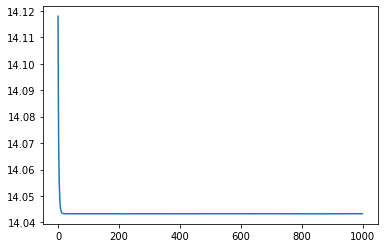

In [182]:
# condition number plot
plt.plot(condNum_array)

/Users/zachariemartin/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


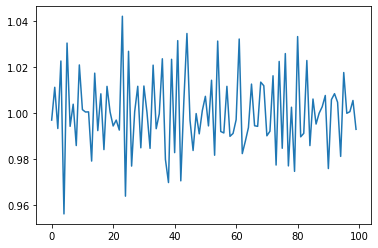

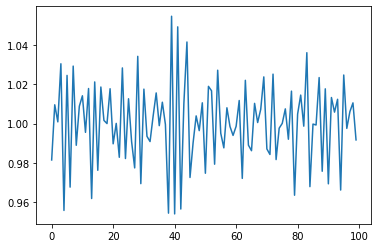

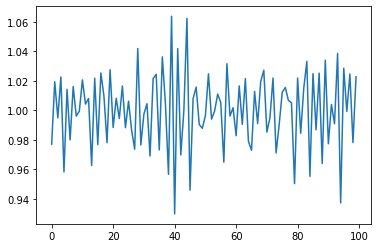

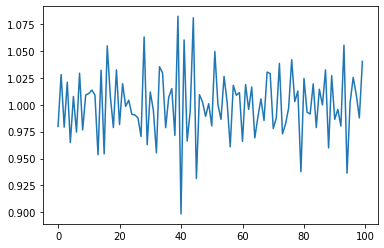

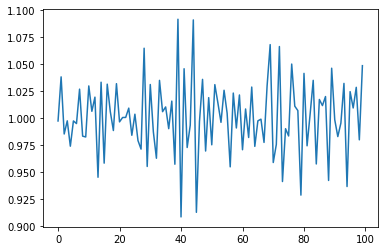

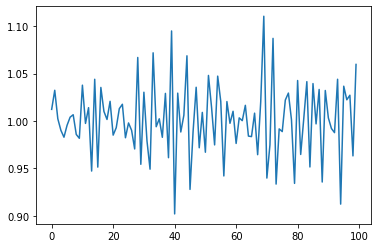

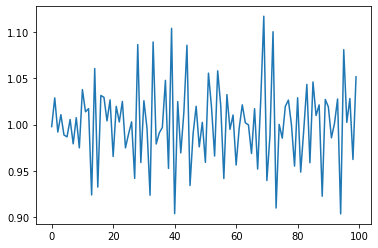

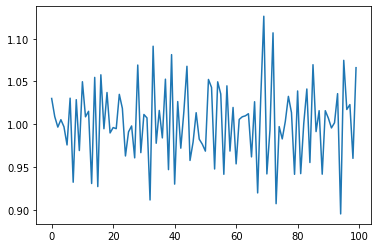

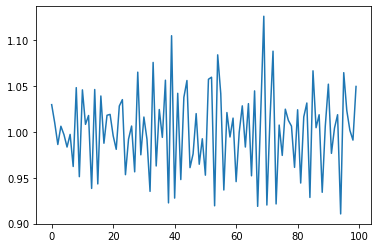

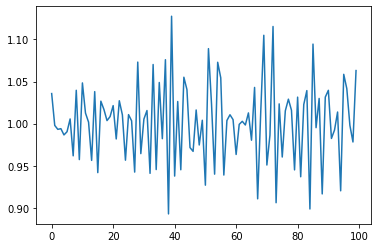

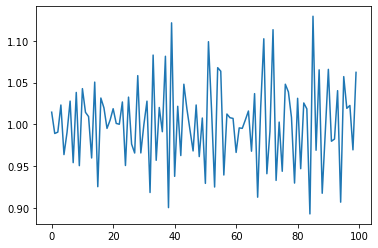

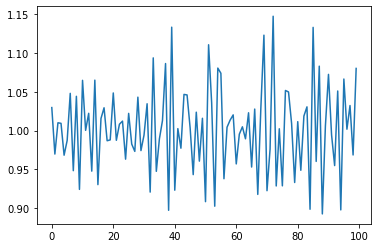

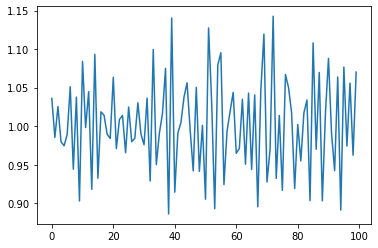

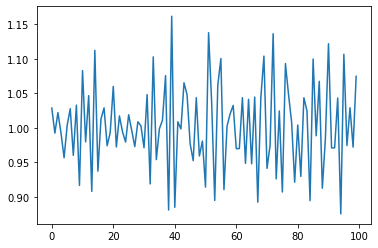

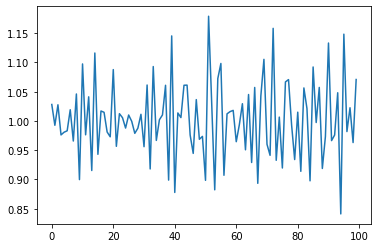

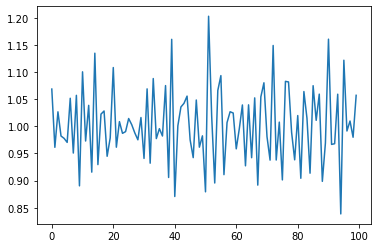

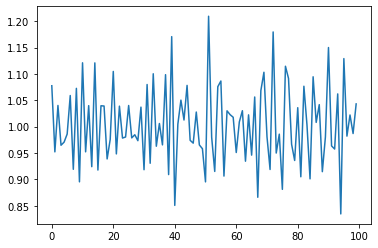

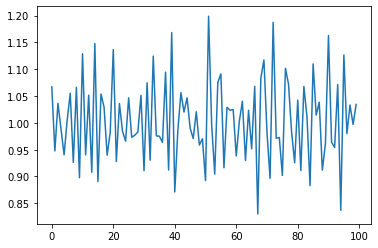

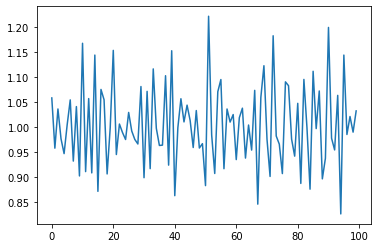

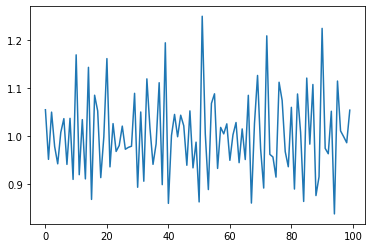

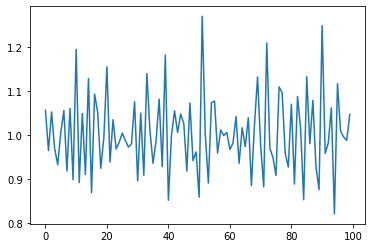

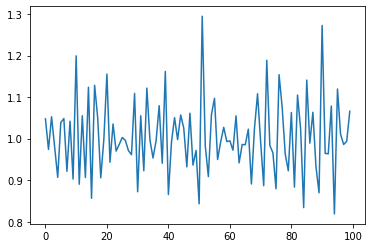

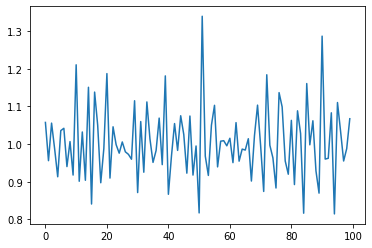

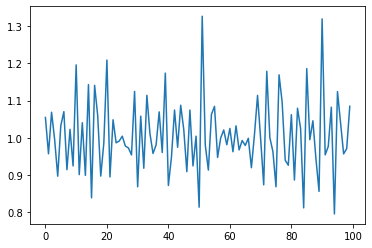

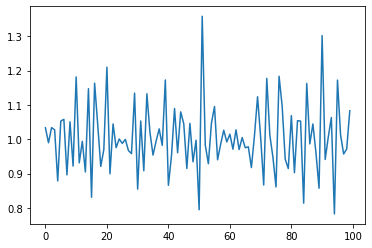

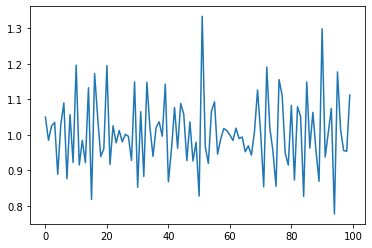

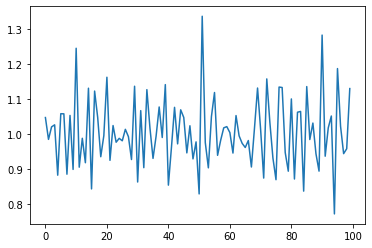

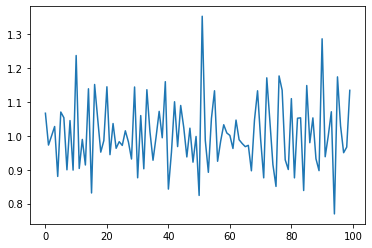

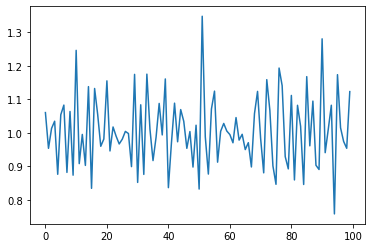

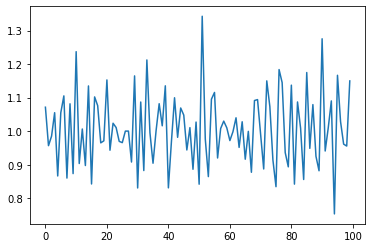

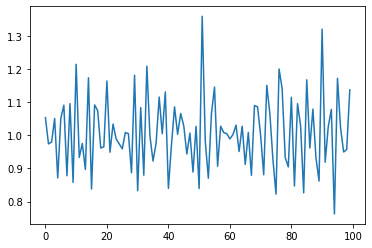

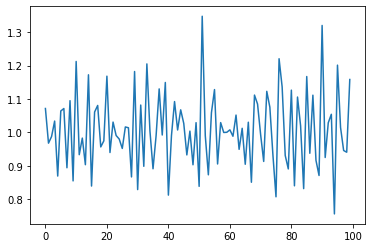

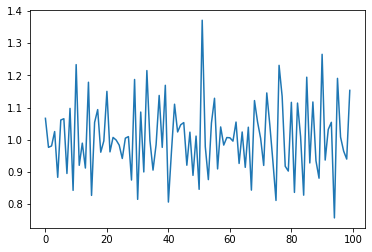

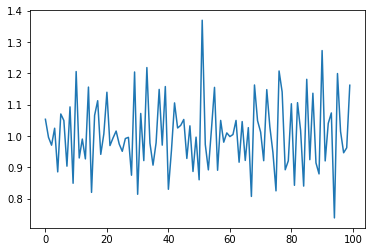

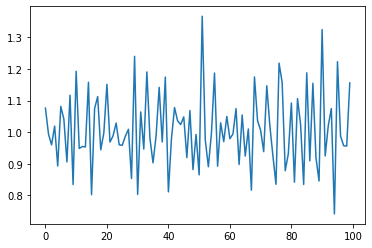

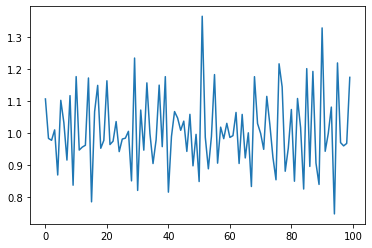

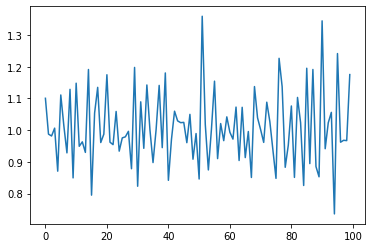

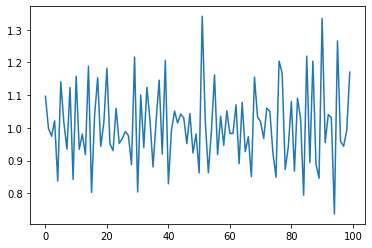

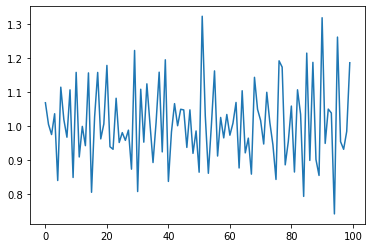

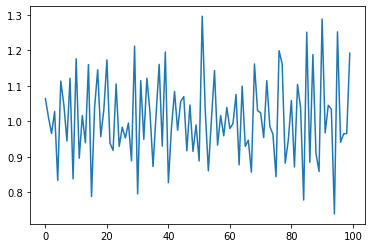

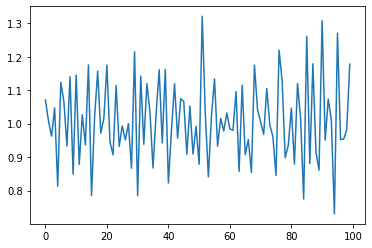

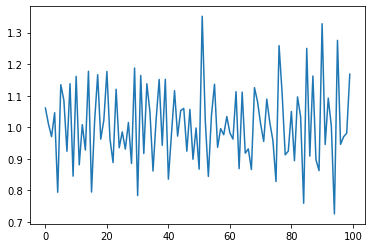

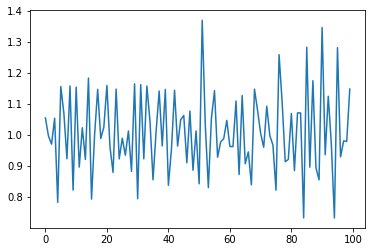

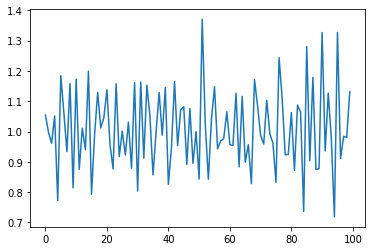

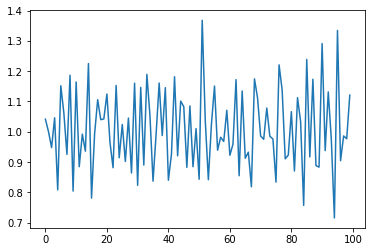

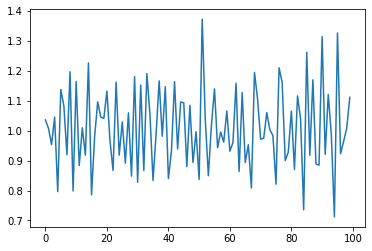

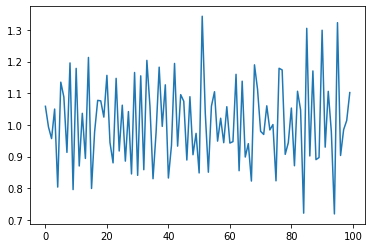

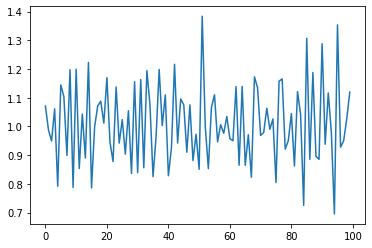

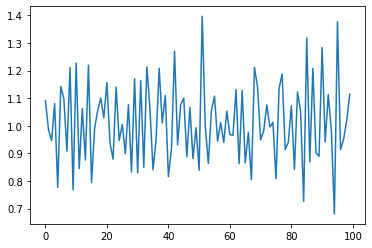

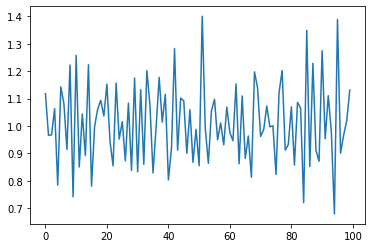

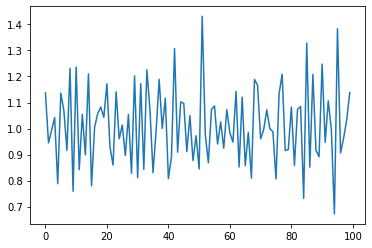

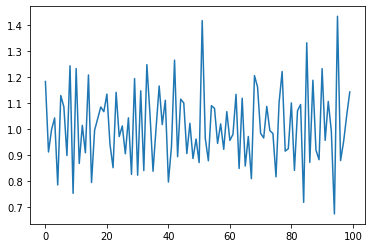

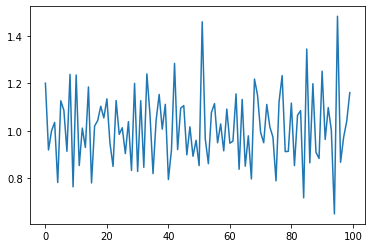

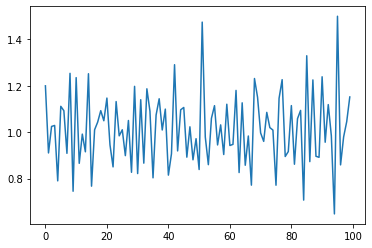

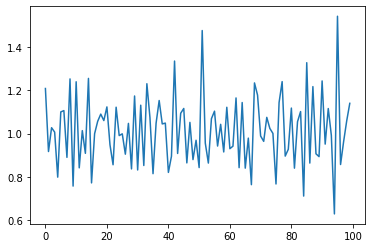

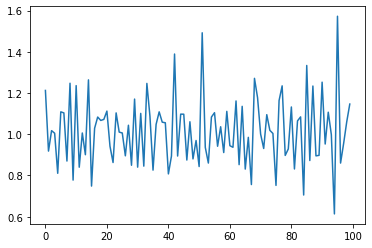

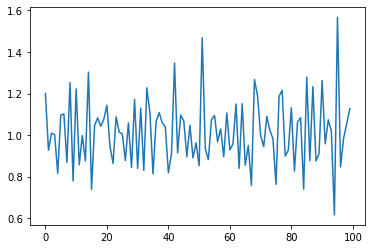

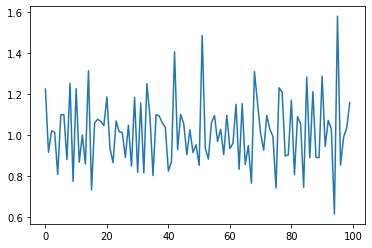

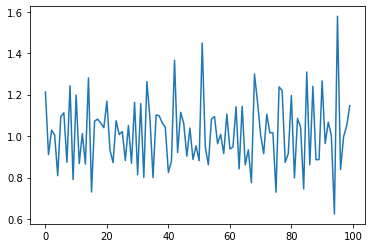

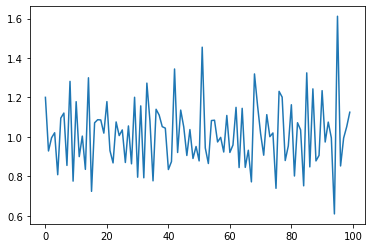

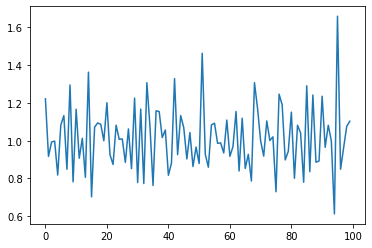

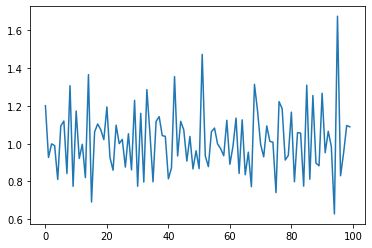

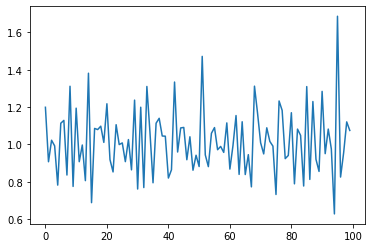

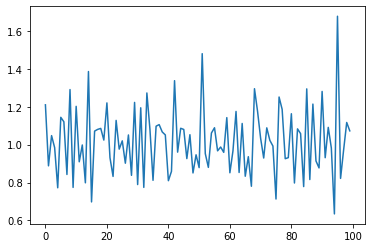

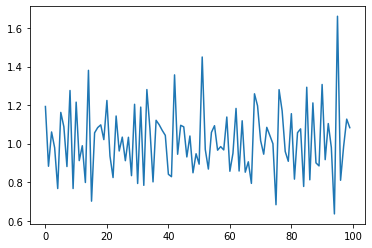

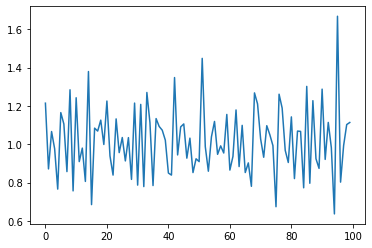

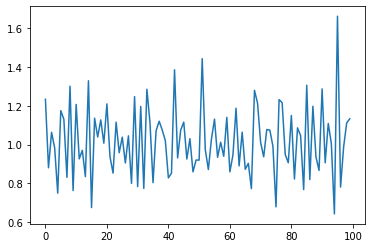

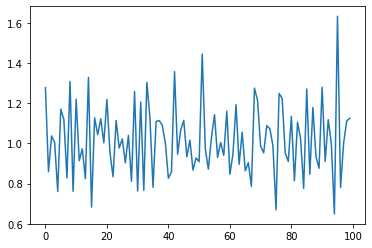

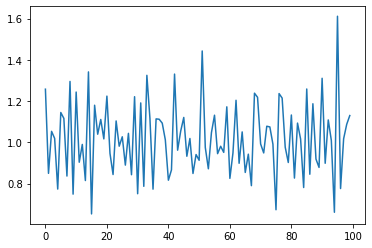

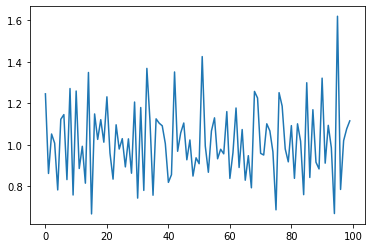

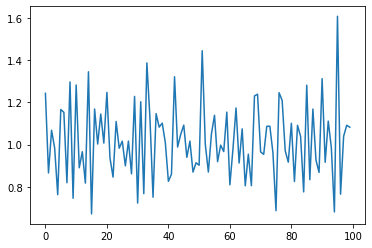

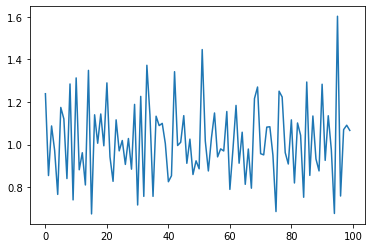

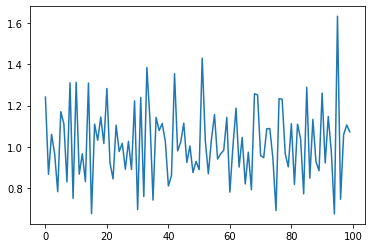

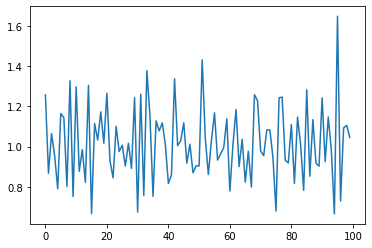

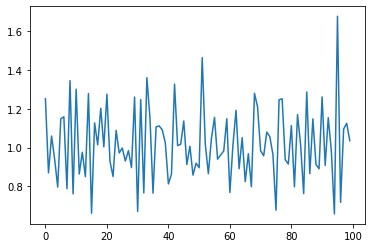

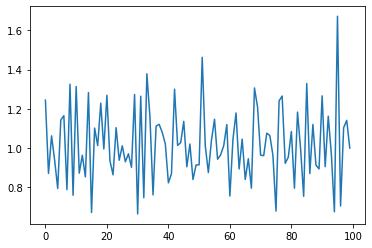

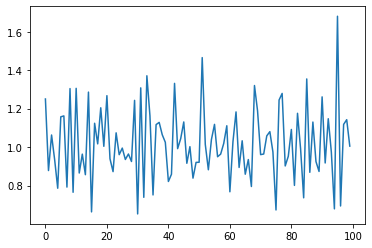

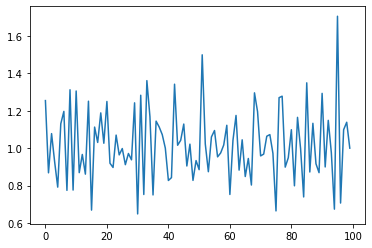

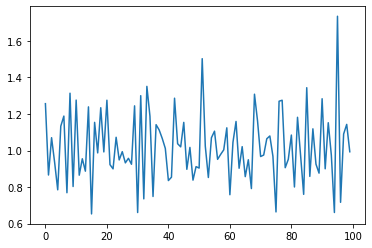

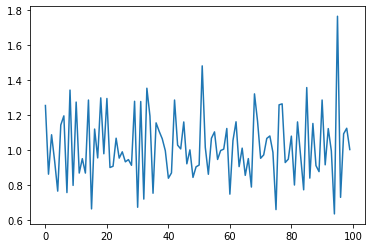

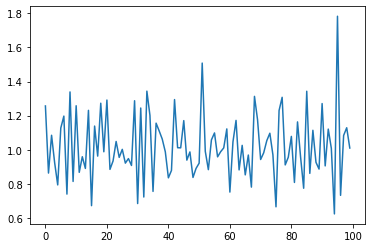

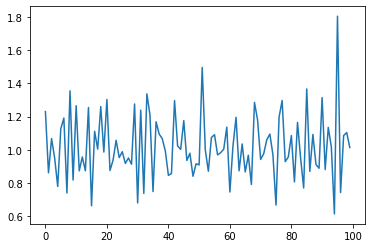

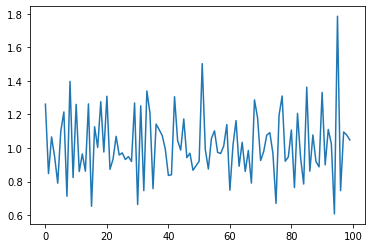

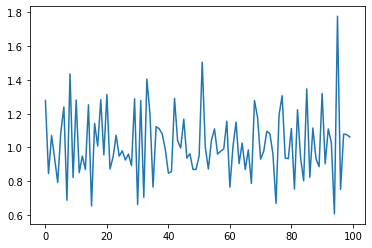

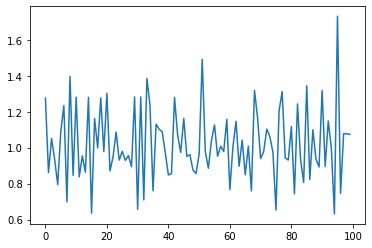

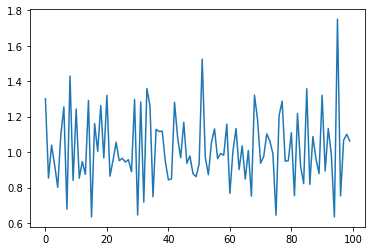

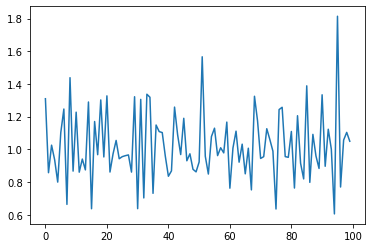

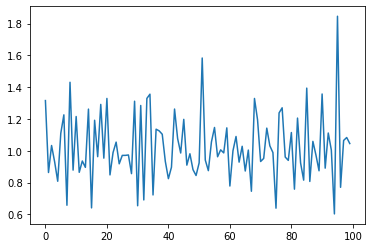

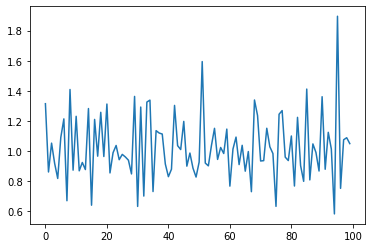

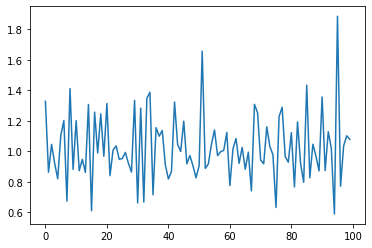

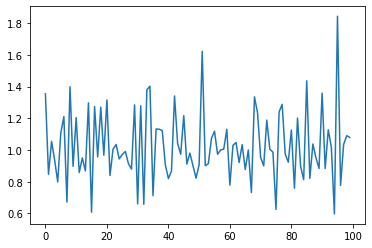

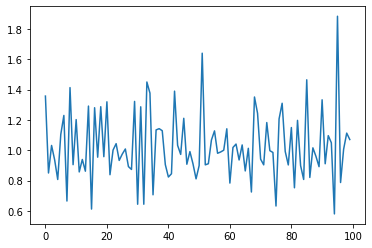

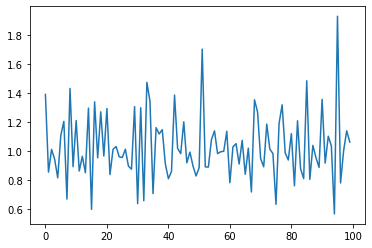

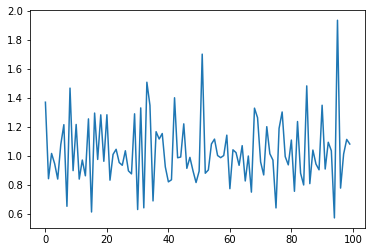

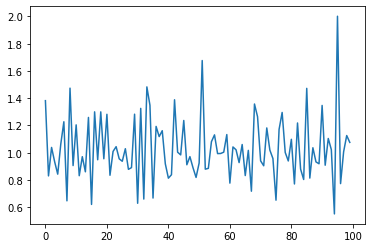

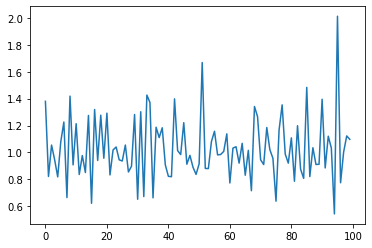

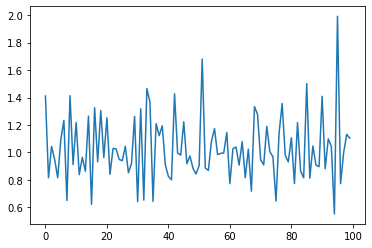

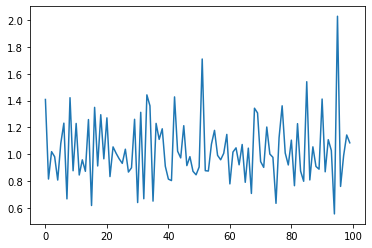

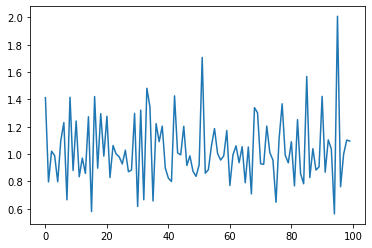

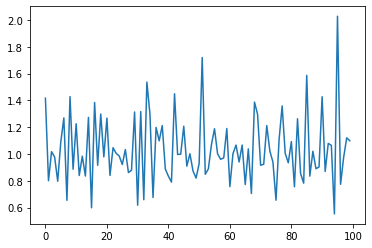

In [184]:
# returns plot
if True:
    for j in range(100):
        plt.figure(j)
        plt.plot([observation[j][i] for i in range(400,500)])